## Data Loading & Libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [117]:
# load the data set
df = pd.read_csv("/Users/kseowoo/Library/CloudStorage/OneDrive-Personal/resume project data and code/Ad click prediction/ad_click_dataset.csv")


In [118]:
# counts of click
df["click"].value_counts()

# counts with proportions
df["click"].value_counts(normalize=True)

click
1    0.632353
0    0.367647
Name: proportion, dtype: float64

## Exploratory Data Analysis (EDA)

In [97]:
print(df.head())
print(df.info())

       id   age  gender device_type ad_position browsing_history time_of_day  \
17    188  56.0  Female      Tablet      Bottom             News     Morning   
25   4890  43.0    Male      Tablet      Bottom        Education   Afternoon   
33   4985  37.0    Male      Mobile         Top             News     Evening   
52   9888  49.0    Male      Mobile         Top             News     Morning   
102  8201  59.0  Female     Desktop      Bottom     Social Media     Morning   

     click  
17       1  
25       1  
33       0  
52       1  
102      0  
<class 'pandas.core.frame.DataFrame'>
Index: 816 entries, 17 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                816 non-null    int64  
 1   age               816 non-null    float64
 2   gender            816 non-null    object 
 3   device_type       816 non-null    object 
 4   ad_position       816 non-null    object 
 5   browsi

In [98]:
# check missing values
print(df.isnull().sum())


id                  0
age                 0
gender              0
device_type         0
ad_position         0
browsing_history    0
time_of_day         0
click               0
dtype: int64


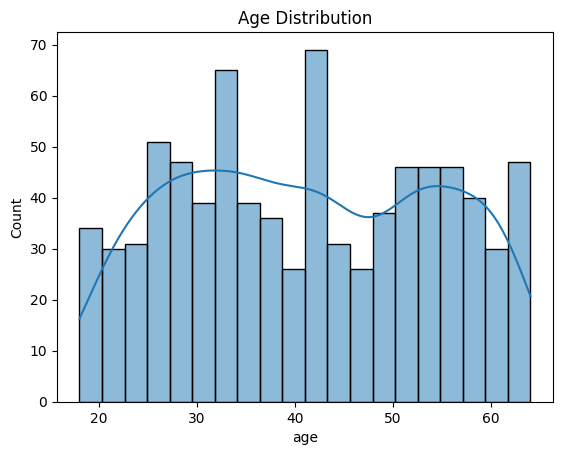

Detected outliers in age:
 Empty DataFrame
Columns: [id, age]
Index: []
Age Min: 18.0
Age Max: 64.0
Age Mean: 41.25
Age Median: 41.0


In [99]:
# check outliers for continuous predictor
# check Age distribution
sns.histplot(df['age'], bins=20, kde=True)
plt.title("Age Distribution")
plt.show()

# check based on IQR
Q1 = df["age"].quantile(0.25)
Q3 = df["age"].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

outliers = df[(df["age"] < lower) | (df["age"] > upper)]
print("Detected outliers in age:\n", outliers[["id","age"]])

print("Age Min:", df["age"].min())
print("Age Max:", df["age"].max())
print("Age Mean:", df["age"].mean())
print("Age Median:", df["age"].median())


There is no outliers and missing values in the dataset.

In [100]:
# make Age a categorical variable
df["age_group"] = pd.cut(df["age"],
                         bins=[17,29, 39, 49, 59,65], 
                         labels=["20s", "30s", "40s", "50s", "60+"])

print(df[["age","age_group"]].head())

      age age_group
17   56.0       50s
25   43.0       40s
33   37.0       30s
52   49.0       40s
102  59.0       50s


In [101]:
print(df.head())
print(df.info())
print(df['click'].value_counts(normalize=True))  # click rate

       id   age  gender device_type ad_position browsing_history time_of_day  \
17    188  56.0  Female      Tablet      Bottom             News     Morning   
25   4890  43.0    Male      Tablet      Bottom        Education   Afternoon   
33   4985  37.0    Male      Mobile         Top             News     Evening   
52   9888  49.0    Male      Mobile         Top             News     Morning   
102  8201  59.0  Female     Desktop      Bottom     Social Media     Morning   

     click age_group  
17       1       50s  
25       1       40s  
33       0       30s  
52       1       40s  
102      0       50s  
<class 'pandas.core.frame.DataFrame'>
Index: 816 entries, 17 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                816 non-null    int64   
 1   age               816 non-null    float64 
 2   gender            816 non-null    object  
 3   device_type       816 non-null    o

In [102]:
# convert data type obejct to category
cat_cols = ["gender", "device_type", "ad_position", "browsing_history", "time_of_day"]

for col in cat_cols:
    df[col] = df[col].astype("category")

print(df.dtypes)

id                     int64
age                  float64
gender              category
device_type         category
ad_position         category
browsing_history    category
time_of_day         category
click                  int64
age_group           category
dtype: object


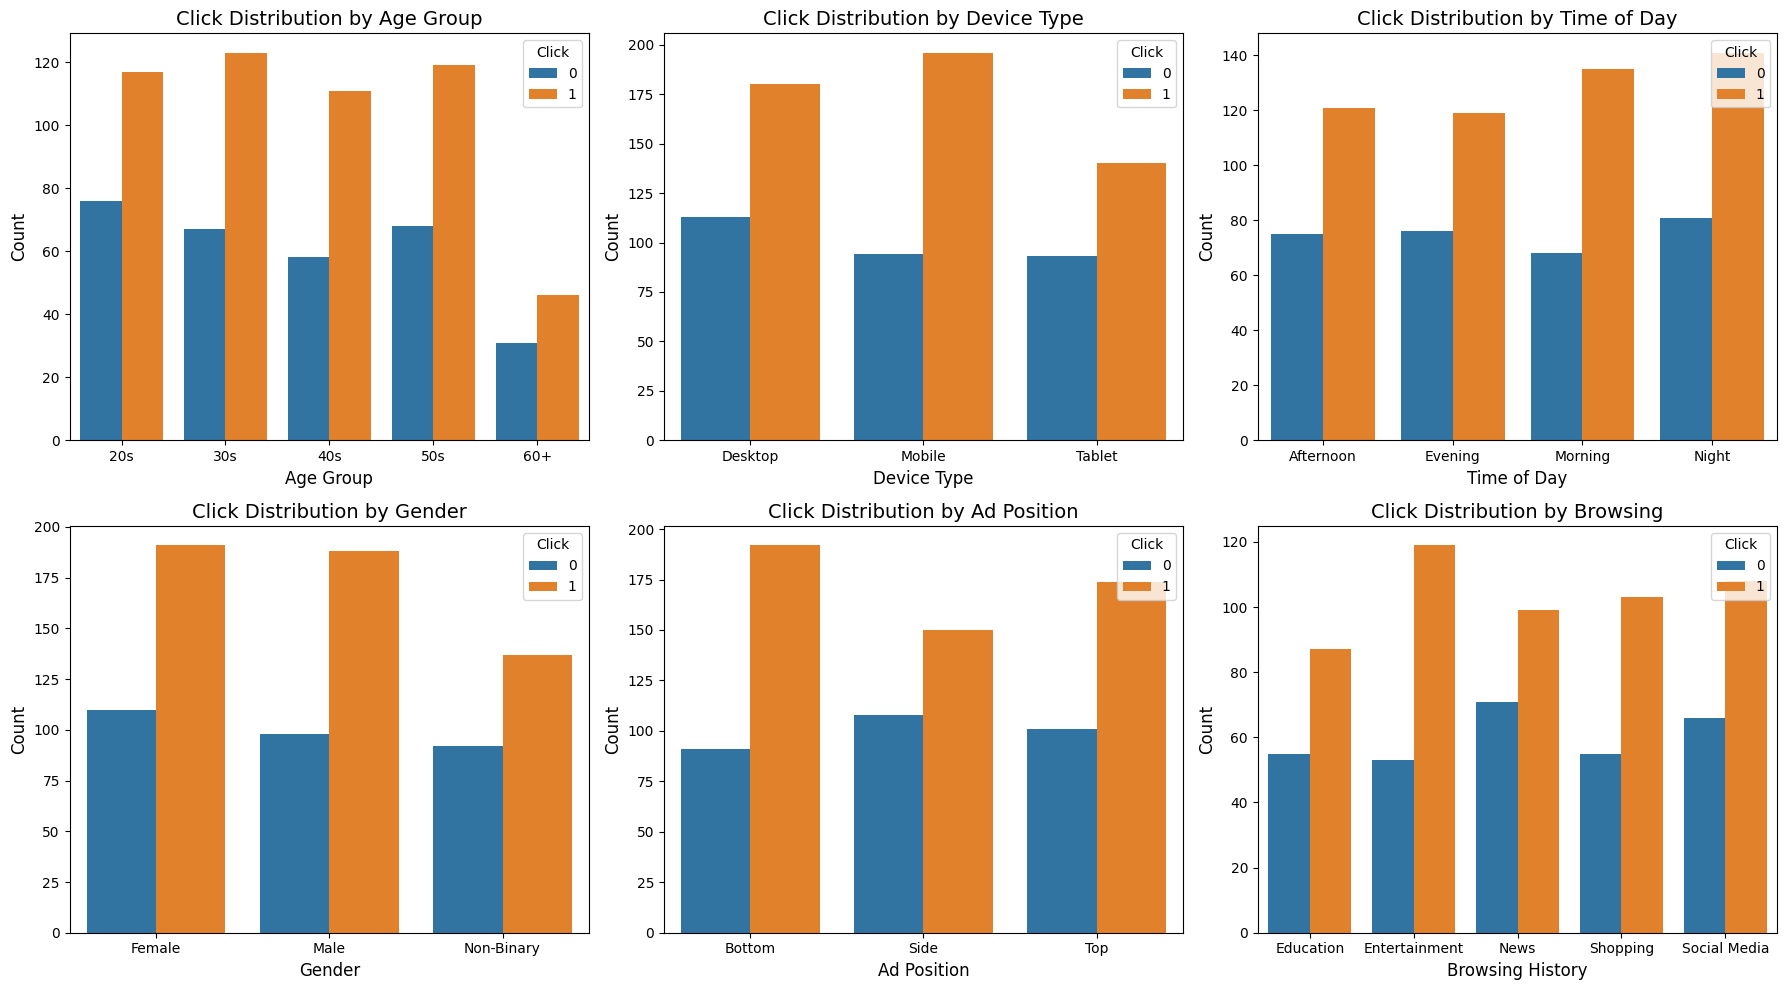

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature list for plot
features = [
    ("age_group", "Click Distribution by Age Group", "Age Group"),
    ("device_type", "Click Distribution by Device Type", "Device Type"),
    ("time_of_day", "Click Distribution by Time of Day", "Time of Day"),
    ("gender", "Click Distribution by Gender", "Gender"),
    ("ad_position", "Click Distribution by Ad Position", "Ad Position"),
    ("browsing_history", "Click Distribution by Browsing", "Browsing History")
]

# generate subplot 2x3
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # 쉽게 인덱싱하기 위해 1차원으로 변환

# countplot for each features
for ax, (col, title, xlabel) in zip(axes, features):
    sns.countplot(data=df, x=col, hue="click", ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.legend(title="Click", loc="upper right")

plt.tight_layout()
plt.show()


/var/folders/fw/m6ywpf3s34j8t26mg50ch4k00000gn/T/ipykernel_22007/962660317.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ctr_df = df.groupby(col)["click"].mean().reset_index()
/var/folders/fw/m6ywpf3s34j8t26mg50ch4k00000gn/T/ipykernel_22007/962660317.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ctr_df = df.groupby(col)["click"].mean().reset_index()
/var/folders/fw/m6ywpf3s34j8t26mg50ch4k00000gn/T/ipykernel_22007/962660317.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

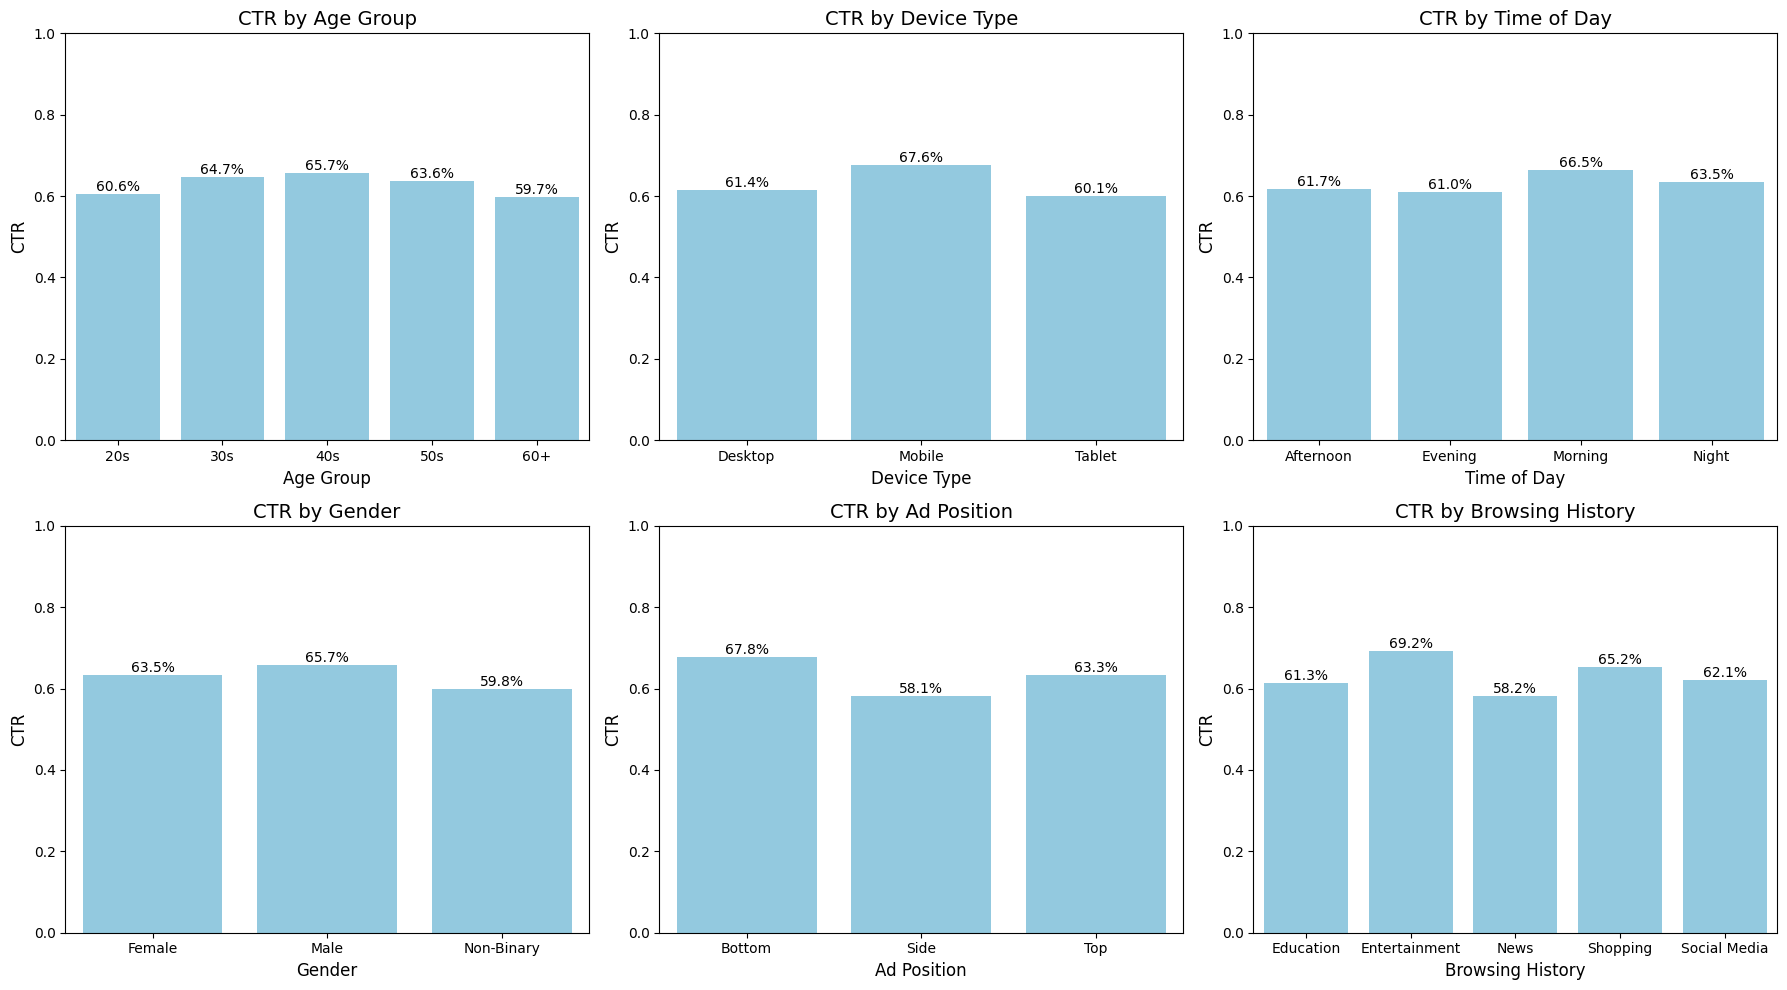

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# feature list for plot
features = [
    ("age_group", "CTR by Age Group", "Age Group"),
    ("device_type", "CTR by Device Type", "Device Type"),
    ("time_of_day", "CTR by Time of Day", "Time of Day"),
    ("gender", "CTR by Gender", "Gender"),
    ("ad_position", "CTR by Ad Position", "Ad Position"),
    ("browsing_history", "CTR by Browsing History", "Browsing History")
]

# 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (col, title, xlabel) in zip(axes, features):
    # calculate CTR by each group
    ctr_df = df.groupby(col)["click"].mean().reset_index()
    
    # CTR plot (one color)
    sns.barplot(data=ctr_df, x=col, y="click", ax=ax, color="skyblue")
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("CTR", fontsize=12)
    ax.set_ylim(0, 1)  # CTR is a proportion
    
    # add CTR percentage labels on top of bars
    ax.bar_label(ax.containers[0], 
                 labels=[f"{v.get_height()*100:.1f}%" for v in ax.containers[0]], 
                 fontsize=10)
    

plt.tight_layout()
plt.show()


In [105]:
# drop id, age(continuous), click(target)
X = pd.get_dummies(
    df.drop(columns=["id", "age", "click"]), 
    drop_first=True
)
y = df["click"]

print("X shape:", X.shape)
print("Feature columns:\n", X.columns.tolist())


X shape: (816, 17)
Feature columns:
 ['gender_Male', 'gender_Non-Binary', 'device_type_Mobile', 'device_type_Tablet', 'ad_position_Side', 'ad_position_Top', 'browsing_history_Entertainment', 'browsing_history_News', 'browsing_history_Shopping', 'browsing_history_Social Media', 'time_of_day_Evening', 'time_of_day_Morning', 'time_of_day_Night', 'age_group_30s', 'age_group_40s', 'age_group_50s', 'age_group_60+']


### Multicollinearity Check

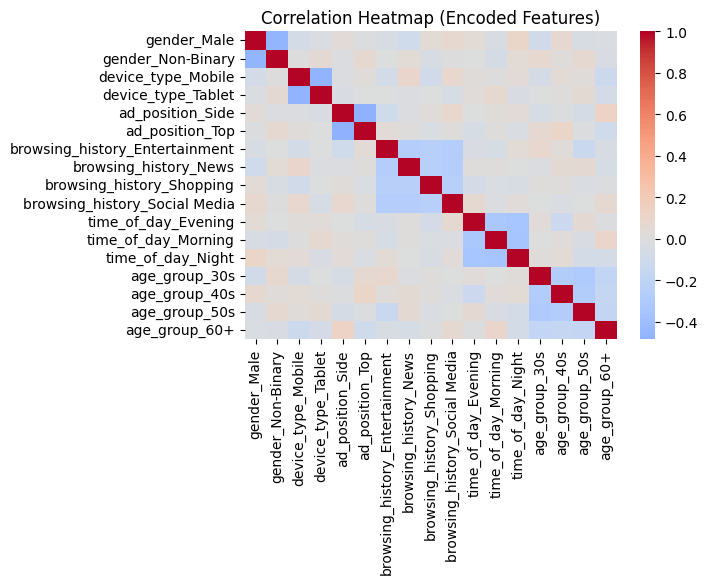

In [106]:
# Correlation Heatmap
plt.figure(figsize=(6,4))
corr = X.corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Encoded Features)")
plt.show()

In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF calculation
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n--- VIF Values ---")
print(vif_data.sort_values("VIF", ascending=False).head(10))



--- VIF Values ---
                           Feature       VIF
16                   age_group_60+  0.017284
9    browsing_history_Social Media  0.011207
7            browsing_history_News  0.010815
14                   age_group_40s  0.010618
8        browsing_history_Shopping  0.010473
6   browsing_history_Entertainment  0.009970
13                   age_group_30s  0.009709
10             time_of_day_Evening  0.009519
15                   age_group_50s  0.009243
11             time_of_day_Morning  0.009152


The VIF analysis indicated no significant multicollinearity, suggesting that the predictors are sufficiently independent for reliable model estimation.

In [108]:
# Logistic Regression (Baseline)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:,1]

print("\n--- Logistic Regression ---")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_log), 3))



--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.31      0.07      0.11        60
           1       0.63      0.91      0.75       104

    accuracy                           0.60       164
   macro avg       0.47      0.49      0.43       164
weighted avg       0.51      0.60      0.51       164

ROC-AUC: 0.523


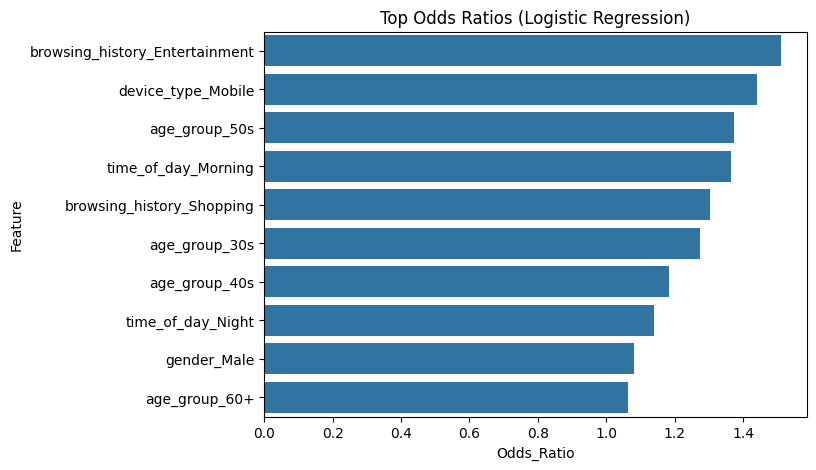

In [109]:
# Odds Ratios
odds_ratios = pd.DataFrame({
    "Feature": X.columns,
    "Odds_Ratio": np.exp(log_model.coef_[0])
}).sort_values(by="Odds_Ratio", ascending=False)

plt.figure(figsize=(7,5))
sns.barplot(x="Odds_Ratio", y="Feature", data=odds_ratios.head(10))
plt.title("Top Odds Ratios (Logistic Regression)")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [19:33:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
              precision    recall  f1-score   support

           0       0.87      0.57      0.69        60
           1       0.79      0.95      0.86       104

    accuracy                           0.81       164
   macro avg       0.83      0.76      0.78       164
weighted avg       0.82      0.81      0.80       164

ROC-AUC: 0.826


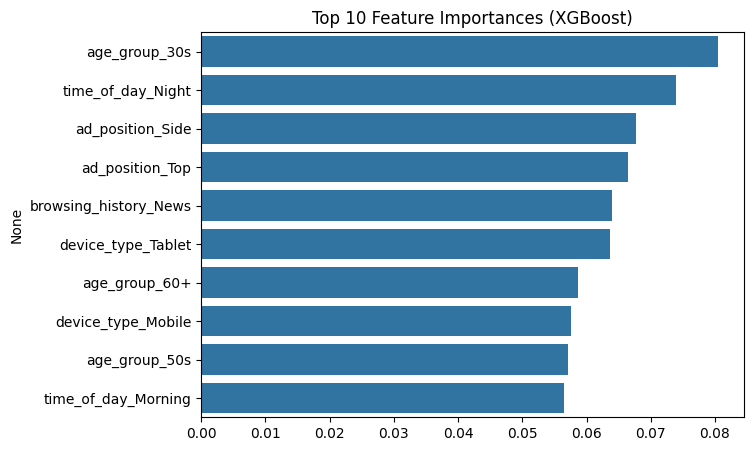

In [110]:
# XGBoost (Main Model)
xgb_model = xgb.XGBClassifier(
    eval_metric="logloss", 
    use_label_encoder=False, 
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

print("\n--- XGBoost ---")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_xgb), 3))

# Feature Importance (Top 10)
feat_imp = pd.Series(
    xgb_model.feature_importances_, 
    index=X.columns
).sort_values(ascending=False).head(10)

plt.figure(figsize=(7,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()


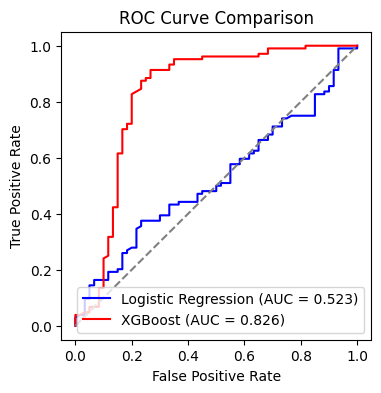

In [121]:
## Compare result between logistic regression and XGBoost
from sklearn.metrics import roc_curve, auc

# ROC curve for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1])
roc_auc_log = auc(fpr_log, tpr_log)

# ROC curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot
plt.figure(figsize=(4,4))
plt.plot(fpr_log, tpr_log, color="blue", label=f"Logistic Regression (AUC = {roc_auc_log:.3f})")
plt.plot(fpr_xgb, tpr_xgb, color="red", label=f"XGBoost (AUC = {roc_auc_xgb:.3f})")

# Random baseline
plt.plot([0,1], [0,1], color="gray", linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()


## Final Results & Business Insights

### Model Performance
- **Logistic Regression (Baseline)**  
  - ROC-AUC: **0.523**  
  - Provides interpretability but limited predictive power.  
- **XGBoost (Main Model)**  
  - ROC-AUC: **0.826**  
  - Delivers substantially stronger predictive performance and captures complex feature interactions.  

Based on these results, **XGBoost was selected as the final model** due to its superior accuracy and robustness.

---

### Key Predictors
- **Age group (30s)** – Strongest predictor of ad clicks, suggesting younger adults are more responsive.  
- **Time of Day (Night)** – Nighttime shows higher engagement, while morning is less influential.  
- **Ad Position (Top, Side)** – Placement significantly impacts CTR, reinforcing the value of premium positions.  
- **Browsing History (News)** – Users consuming news content are more likely to engage with ads.  
- **Device Type (Mobile, Tablet)** – Mobile-first strategy is supported by higher click activity.

---

### Strategic Takeaways
1. **Targeting**: Focus on **younger demographics (30s)** with campaigns designed for their preferences.  
2. **Timing**: Schedule campaigns during **evening hours** to leverage peak engagement.  
3. **Placement**: Prioritize **top and side positions** for higher visibility and click-through rates.  
4. **Personalization**: Use browsing history to deliver **context-relevant ads** (e.g., news readers).  

